# Generate Data and Make Plots for the Paper

This notebook will generate all of the data and plots used in the paper. Please refer to **Evaluating Black Hole Detectability with LISA** (arXiv:1807.02511). The tool used to perform this analysis is BOWIE, Binary Observability With Illustrative Exploration. See "BOWIE_basic_examples.ipynb" for information on building data sets and basic plots with BOWIE. All of these data will be produced in parallel with the multiprocessing module in python. The noise curves shown can be found in the form of an amplitude spectral density (ASD) in the "noise_curves" folder in the github. 

Please refer to and cite (arXiv:1807.02511) for usage of this tool and an example of its application. The codes here are shared under the GNU license. 

In [1]:
from bowie_makeplot.make_plot import plot_main
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyphenomd.pyphenomd import *
import scipy.constants as ct
from bowie_gencondata.generate_contour_data import generate_contour_data
from astropy.io import ascii
Msun = 1.989e30

/Users/michaelkatz/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Figure 1: Sensitivity Curves

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,8)
for name in ['PLHB', 'PLCS', 'CLLF', 'PL', 'CL', 'WDnoise']:
    noise_data = ascii.read('../noise_curves/' + name + '.txt')
    f = noise_data['f']
    ASD = noise_data['ASD']
    hn = np.sqrt(f)*ASD
    
    if name == 'PL':
        name = 'Proposed LISA (PL)'
    if name == 'CL':
        name = 'Classic LISA (CL)'
    if name == 'WDnoise':
        name = 'Galactic Background (GB)'
    plt.loglog(f, hn, label = name)

plt.xlim(5e-6,1e0)
plt.ylim(1e-22, 1e-13)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$h_n$ (Characteristic Strain)', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=22)
plt.legend(loc='upper right', prop={'size':16})
fig.savefig('Sensitivity_curves.pdf', dpi=250)

## Figure 2: Waveform Example

In [ ]:
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig1.set_size_inches(8,6)
plt.subplots_adjust(wspace=0.0, left=0.15, bottom=0.15)

M = 1e5
z = 1.0
start_time = 1.0
end_time = 0.0
ax1.set_title(r'$q=1$', fontsize=20)
ax2.set_title(r'$q=10^{2}$', fontsize=20)
for q, ax in [[1, ax1], [1/100,ax2]]:
    ax.set_ylim(6e-23, 3e-18)
    ax.set_xlim(8e-5, 1e0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    for s, ls in [[-1.0, 'dotted'], [0.0, 'solid'], [1.0,'dashed']]:
        m1 = M/(1+q)
        m2 = M*q/(1+q)
        wave = PhenomDWaveforms(m1, m2, s, s, z, start_time, end_time, num_points=4096)
        wave.create_waveforms()
        
        f = wave.freqs
        hc = wave.amplitude*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018
        
        ins = np.where(f<wave.fmrg)[0]
        mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
        rd = np.where(f>wave.fpeak)[0]
        
        ax.loglog(f[ins], hc[ins], color='blue', ls = ls, lw = 2)
        ax.loglog(f[mrg], hc[mrg], color='green', ls = ls, lw = 2)
        ax.loglog(f[rd], hc[rd], color='brown', ls = ls, lw = 2)
        if s == 0.0:
            N = m1*m2/(m1+m2)**2.
            start_times = np.array([1.0,1.0/12.0, 1.0/365.25,1.0/(365.25*24.0)])*ct.Julian_year/(1+z)

            tau = N*(start_times*ct.c)/(5.*(m1+m2)*Msun*ct.G/(ct.c**2.))
            flow = 1./(8.*ct.pi*(m1+m2)*Msun*ct.G/(ct.c**2.)*tau**(3./8.))*(1.+((11./32)*N+743./2688.)*tau**(-1./4.))*ct.c/(1+z)

            f_1y_ind = np.where(f >= flow[0])[0][0]
            f_1m_ind = np.where(f >= flow[1])[0][0]
            f_1d_ind = np.where(f >= flow[2])[0][0]
            f_1h_ind = np.where(f >= flow[3])[0][0]

            ax.annotate("Year",xy=(f[f_1y_ind], hc[f_1y_ind]), xycoords='data',xytext=(0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            ax.annotate("Month",xy=(f[f_1m_ind], hc[f_1m_ind]), xycoords='data',xytext=(0.0, 47), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            ax.annotate("Day",xy=(f[f_1d_ind], hc[f_1d_ind]), xycoords='data',xytext=(0.0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            ax.annotate("Hour",xy=(f[f_1h_ind], hc[f_1h_ind]), xycoords='data',xytext=(0.0, +63), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)

ax1.plot(1,1, color='blue', ls='solid', label='Inspiral')
ax1.plot(1,1, color='green', ls='solid', label='Merger')
ax1.plot(1,1, color='brown', ls='solid', label='Ringdown')
ax1.plot(1,1, color='black', ls='solid', label='No Spin')
ax1.plot(1,1, color='black', ls='dotted', label='Spin Down')
ax1.plot(1,1, color='black', ls='dashed', label='Spin Up')
ax1.legend(loc='lower left', prop={'size':13})
ax1.set_ylabel(r'$h_c$', fontsize = 22)
ax1.set_xticks([1e-3, 1e-2, 1e-1])

fig1.text(0.5, 0.05, 'Frequency (Hz)', ha = 'center', fontsize=22)
fig1.savefig('Phase_tracks1.pdf', dpi=250)

## Figure 3: $h_c$ vs. $h_n$

In [ ]:
fig2 = plt.figure()
fig2.set_size_inches(10,8)
for name in ['PLHB', 'PLCS', 'CLLF', 'PL', 'CL', 'WDnoise']:
    noise_data = ascii.read('../noise_curves/' + name + '.txt')
    f = noise_data['f']
    ASD = noise_data['ASD']
    hn = np.sqrt(f)*ASD
    if name == 'WDnoise':
        name = 'GB'
    plt.loglog(f, hn, label = name, ls='dashed')
    
q = 1.0
s = 0.0
start_time = 1.0
end_time = 0.0
for M, z, letter in [[7e8, .75, 'A'],[6e7,20.0, 'B'], [1e6, 1.0, 'C'], [1e4, 2.5, 'D']]:
    m1 = M/(1+q)
    m2 = M*q/(1+q)
    wave = PhenomDWaveforms(m1, m2, s, s, z, start_time, end_time, num_points=4096)
    wave.create_waveforms()

    f = wave.freqs
    hc = wave.amplitude*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018

    print(letter, 'SNR =', [snr(m1, m2, s, s, z, start_time, end_time, wd_noise=True, prefactor=np.sqrt(2*16/5) , sensitivity_curve=sc) for sc in ['PL', 'CL', 'PLHB', 'PLCS', 'CLLF']])
    
    ins = np.where(f<wave.fmrg)[0]
    mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
    rd = np.where(f>wave.fpeak)[0]

    plt.loglog(f[ins], hc[ins], color='blue', lw=2)
    plt.loglog(f[mrg], hc[mrg], color='green', lw=2)
    plt.loglog(f[rd], hc[rd], color='brown', lw=2)
    
    if letter == 'B':
        plt.text(f[rd][0]*0.93, hc[rd][0]*1.28, letter, fontdict={'fontsize':16})
    else:
        plt.text(f[rd][0]*1.12, hc[rd][0]*1.12, letter, fontdict={'fontsize':16})


plt.plot(1,1, color='blue', lw=2, label='Inspiral')
plt.plot(1,1, color='green', lw=2, label='Merger')
plt.plot(1,1, color='brown', lw=2, label='Ringdown')

plt.xlim(5e-6,1e0)
plt.ylim(1e-22, 1e-13)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'Characteristic Strain', fontsize=22)
plt.xlabel('Frequency (Hz)', fontsize=22)
plt.legend(loc='upper right', ncol = 3, prop={'size':15})
fig2.savefig('Phase_tracks2.pdf', dpi=250)

## Figure 4: Main Comparison with Galactic Background Noise

In [ ]:
main_comp_generate = {

"general":
    {
    "WORKING_DIRECTORY": ".",
    "signal_type": ["all", "ins", "mrg", "rd"],
    "generation_type": "parallel",
    "num_processors": 4,
    "num_splits":2000,
    "add_wd_noise": "both"
    },

"output_info":
    {
    "output_folder": "paper_data",
    "output_file_name":"q5_s65_new_check",
    "output_file_type":"hdf5",
    "x_col_name": "M_s",
    "y_col_name": "z",
    "added_note": "The White Dwarf Noise is the Hils-Bender Approximation."
    },


"input_info":
    {
    "input_folder": "noise_curves",
    "freq_column_label": "f",
    "amplitude_column_label": "ASD", 
    "sensitivity_curves": 
        [
        {"name":"PL.txt", "type":"ASD"}, 
        #{"name":"CL.txt", "type":"ASD"}, 
        #{"name":"PLHB.txt", "type":"ASD"}, 
        #{"name":"PLCS.txt", "type":"ASD"}, 
        #{"name":"CLLF.txt", "type":"ASD"} 
         {"name":"NPL.txt", "type":"PSD", "amplitude_column_label": "PSD"}, 
        ],
    "sensitivity_averaging_factor":0.3872983346,
    "input_folder":"../noise_curves",
    "Galactic_background": 
        {"name":"WDnoise.txt", "type":"ASD"}
    },

"generate_info":
    {
    "xscale": "log",
    "num_x": 500,
    "x_low": 1e2,
    "x_high": 1e10,
    "xval_name": "total_mass",
    "xval_unit": "SolarMasses",

    "yscale": "log",
    "num_y": 500,
    "y_low": 1e-2,
    "y_high": 2e1,
    "yval_name": "redshift",

    "yval_unit": "None",

    "fixed_parameter_1": 0.2,
    "par_1_name": "mass_ratio",
    "par_1_unit": "None",

    "fixed_parameter_2": 0.8,
    "par_2_name": "spin_1",
    "par_2_unit": "None",

    "fixed_parameter_3": 1.0,
    "par_3_name": "start_time",
    "par_3_unit": "Years",

    "fixed_parameter_4": 0.0,
    "par_4_name": "end_time",
    "par_4_unit": "Years",
        
    "fixed_parameter_5": 0.8,
    "par_5_name": "spin_2",
    "par_5_unit": "None",

    "freq_length": 4096,
        
    "snr_calculation_factors":
        {
        "averaging_factor": 0.692820323,
        "snr_factor": 1.4142135624 #sqrt(2)
        }
    }
}

generate_contour_data(main_comp_generate)

/Users/michaelkatz/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


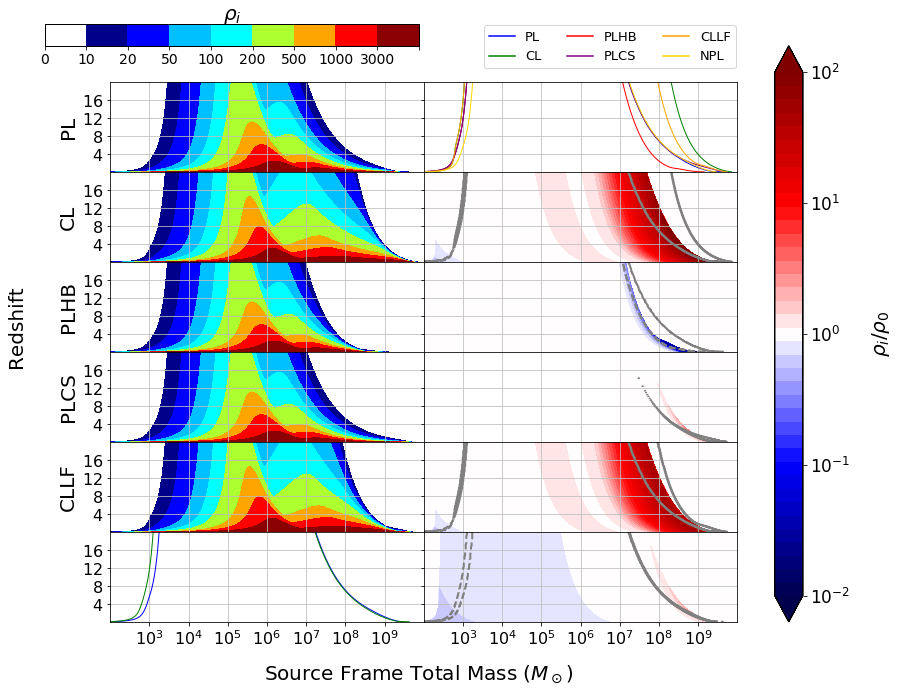

In [3]:
main_comp_plot_WD = {
"general":{
    "WORKING_DIRECTORY": ".",
    
    "save_figure":False,
    "output_path": "plot_outputs/main_comp_change.pdf",

    "SNR_CUT": 5.0,
        
    "file_name": "paper_data/q5_s65.hdf5",

    "x_column_label": "M_s",
    "y_column_label": "z", 

    "figure_width": 13.0,
    "figure_height": 10.0,
    "spacing": "tight",
    "fig_y_label": "Redshift",
    "fig_x_label": r"Source Frame Total Mass ($M_\odot$)",
        
    "tick_label_fontsize":16,

    "num_rows": 6,
    "num_cols": 2,

    "xlims": [2.0, 10.0],
    "dx": 1.0,
    "xscale": "log",

    "ylims": [0.0, 20.0],
    "dy": 4.0,
    "yscale": "lin",
    "colorbars":
        {"Waterfall":{"pos":3, "ticks_fontsize":14}, "Ratio":{"pos":5}}
    },



"plot_info":
    {

    "0":{
        "file":[
            {
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL"}
        },
        
    "1":{
        "indices": [0, 2, 4, 6, 8, 10],
        "type": "Horizon",
        "legend":
            {
            "labels": ["PL", "CL", "PLHB", "PLCS", "CLLF", "NPL"],
            "bbox_to_anchor": [0.17, 1.7],
            "size":13,
            "ncol": 3
            }
        },
        
    "2":{
        "file":[
            {"label":"CL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL"}
        },
    "3":{
        "indices": 2,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "4":{
        "file":[
            {"label":"PLHB_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PLHB"}
        },
    "5":{
        "indices": 4,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "6":{
        "file":[
            {"label":"PLCS_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PLCS"}
        },
    "7":{
        #"indices": 6,
        "file":[{"name": "paper_data/q5_s65_high_res.hdf5", "label":"PLCS_wd_all"}],
        "control":
            #{"index": 0},
            {"name": "paper_data/q5_s65_high_res.hdf5", "label":"PL_wd_all"},
        "type": "Ratio",
        },
    "8":{
        "file":[
            {"label":"CLLF_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CLLF"}
        },
    "9":{
        "indices": 8,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "10":{
        "file": [{"name": "paper_data/q5_s65_new_check.hdf5", "label":"NPL_wd_all"},
                {"name": "paper_data/q5_s65_new_check.hdf5", "label":"PL_wd_all"}],
        "type": "Horizon",
        },
    
    "11":{
        "file": [{"name": "paper_data/q5_s65_new_check.hdf5", "label":"NPL_wd_all"}],
        "control":
            {"name": "paper_data/q5_s65_new_check.hdf5", "label":"PL_wd_all"},
        "type": "Ratio",
        }
    }
}


plot_main(main_comp_plot_WD)

## Figure 5: Stage of Coalescence Comparison

In [ ]:
stage_plot = {
"general":{
    "WORKING_DIRECTORY": ".",
    
    "save_figure":True,
    "output_path": "plot_outputs/phase_comp_wd.pdf",

    "SNR_CUT": 5.0,
        
    "file_name": "paper_data/q5_s65.hdf5",



    "x_column_label": "M_s",
    "y_column_label": "z", 

    "figure_width": 13.0,
    "figure_height": 10.0,
    "spacing": "tight",
    "fig_y_label": "Redshift",
    "fig_x_label": r"Source Frame Total Mass ($M_\odot$)",
        
    "tick_label_fontsize":16,

    "num_rows": 6,
    "num_cols": 2,

    "xlims": [2.0, 10.0],
    "dx": 1.0,
    "xscale": "log",

    "ylims": [0.0, 20.0],
    "dy": 4.0,
    "yscale": "lin",
        
    "colorbars":
        {"Waterfall":{"pos":3, "ticks_fontsize":14}, "Ratio":{"pos":5}}
    },



"plot_info":
    {

    "0":{
        "file":[
            {
             "label":"PL_wd_ins"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nINS","ylabel_fontsize":13}
        },
        
    "1":{
        "indices": [0, 2],
        "type": "Horizon",
        "legend":
            {
            "labels": ["PL", "CL"],
            "bbox_to_anchor": [0.32, 1.7],
            "size":15,
            "ncol": 2
            },
        "extra":
            {
            "snr_contour_value":100
            }
        },
        
    "2":{
        "file":[
            {"label":"CL_wd_ins"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nINS","ylabel_fontsize":13}
        },
    "3":{
        "indices": 2,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "4":{
        "file":[
            {"label":"PL_wd_mrg"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nMRG","ylabel_fontsize":13}
        },
    "5":{
        "indices": [4, 6],
        "type": "Horizon",
        "extra":
            {
            "snr_contour_value":100
            }
        },
    "6":{
        "file":[
            {"label":"CL_wd_mrg"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nMRG","ylabel_fontsize":13}
        },
    "7":{
        "indices": 6,
        "control":
            {"index": 4},
        "type": "Ratio",
        },
    "8":{
        "file":[
            {"label":"PL_wd_rd"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nRD","ylabel_fontsize":13},
        "extra":
            {'snr_contour_value': 21.221441}
        },
    "9":{
        "indices": [8, 10],
        "type": "Horizon",
        "extra":
            {
            "snr_contour_value":100
            }
        },
    "10":{
        "file":[
            {"label":"CL_wd_rd"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nRD","ylabel_fontsize":13},
        "extra":
            {'snr_contour_value': 21.221441}
        },
    "11":{
        "indices": 10,
        "control":
            {"index": 8},
        "type": "Ratio",
        },
    }
}



plot_main(stage_plot)

## Figure 6: Spin and Mass Ratio Comparison 

In [ ]:
spin_mass_generate = main_comp_generate.copy()
spin_mass_generate["input_info"]['sensitivity_curves'] =  [
        {"name":"PL.txt", "type":"ASD"}, 
        {"name":"CL.txt", "type":"ASD"} 
        ]

#generate_fig_8_dict['generate_info']['fixed_parameter_1'] = 0.002
spin_mass_generate['generate_info']['par_2_name'] = 'spin'
spin_mass_generate['generate_info']['par_5_name'] = 'same_spin'

for mr in [0.02, 0.2, 0.002]:
    spin_mass_generate['generate_info']['fixed_parameter_1'] = mr
    spin_mass_generate["output_info"]["output_file_name"] = "q%i_s65"%(int(1/mr))

    for spin in [-0.99, 0.0, 0.99]:
        spin_mass_generate['generate_info']['fixed_parameter_2'] = spin
        spin_mass_generate['generate_info']['fixed_parameter_5'] = spin

        if spin != -0.99:
            spin_mass_generate["output_info"]["output_file_name"] = "q%i_s%i"%(int(1/mr), int(100*spin))

        else:
            spin_mass_generate["output_info"]["output_file_name"] = "q%i_sn%i"%(int(1/mr), int(-100*spin))

        generate_contour_data(spin_mass_generate)

In [ ]:
spin_mass_plot = {
"general":{
    "WORKING_DIRECTORY": "paper_data",
    
    "save_figure":True,
    "output_path": "../plot_outputs/spin_mass_ratio_comp_wd.png",


    "SNR_CUT": 5.0,
        
    "x_column_label": "M_s",
    "y_column_label": "z", 

    "figure_width": 13.0,
    "figure_height": 10.0,
    "adjust_figure_bottom":  0.13,
    "spacing": "tight",
    "fig_y_label": "Redshift",
    "fig_x_label": r"Source Frame Total Mass ($M_\odot$)",
        
    "tick_label_fontsize":16,

    "num_rows": 3,
    "num_cols": 4,

    "xlims": [2.0, 10.0],
    "dx": 2.0,
    "xscale": "log",

    "ylims": [0.0, 20.0],
    "dy": 4.0,
    "yscale": "lin",
    "colorbars":
        {"Waterfall":{"pos":3, "ticks_fontsize":14}, "Ratio":{"pos":5}},
    #"x_tick_label_fontsize":12
    },



"plot_info":
    {

    "0":{
        "file":[
            {"name":"q50_s99.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": r"$a=0.99$","ylabel_fontsize":16},
        "control":
            {"name":"q5_s99.hdf5",
             "label":"PL_wd_all"}
            
        },
        
    "1":{
        "file":[
            {"name":"q50_s99.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Ratio",

        "control":
            {"name":"q50_s99.hdf5",
             "label":"PL_wd_all"}
            
        },
        
    "3":{
        "file":[
            {"name":"q500_s99.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Ratio",
        "control":
            {"name":"q500_s99.hdf5",
             "label":"PL_wd_all"}
            
        },
     "2":{
        "file":[
            {"name":"q500_s99.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "control":
            {"name":"q5_s0.hdf5",
             "label":"PL_wd_all"}
            
        },
        
    "4":{
        "file":[
            {"name":"q50_s0.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": r"$a=0.0$","ylabel_fontsize":16},
        "control":
            {"name":"q50_s0.hdf5",
             "label":"PL_wd_all"}
            
        },
        
    "5":{
        "file":[
            {"name":"q50_s0.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Ratio",
        "control":
            {"name":"q50_s0.hdf5",
             "label":"PL_wd_all"}
            
        },
    "7":{
        "file":[
            {"name":"q500_s0.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Ratio",
        "control":
            {"name":"q500_s0.hdf5",
             "label":"PL_wd_all"}
            
        },
        
    "6":{
        "file":[
            {"name":"q500_s0.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"xlabel": "q=50","xlabel_fontsize":16},
        "control":
            {"name":"q50_sn99.hdf5",
             "label":"PL_wd_all"}
            
        },
        
    "8":{
        "file":[
            {"name":"q50_sn99.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": r"$a=-0.99$","ylabel_fontsize":16, "xlabel": r"$q=50$","xlabel_fontsize":16},
        "control":
            {"name":"q500_sn99.hdf5",
             "label":"PL_wd_all"},
        },
    "9":{
        "file":[
            {"name":"q50_sn99.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Ratio",
        "label":
            {"xlabel": r"$q=50$","xlabel_fontsize":16},
        "control":
            {"name":"q50_sn99.hdf5",
             "label":"PL_wd_all"}
            
        },
    "11":{
        "file":[
            {"name":"q500_sn99.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Ratio",
        "label":
            {"xlabel": r"$q=500$","xlabel_fontsize":16},
        "control":
            {"name":"q500_sn99.hdf5",
             "label":"PL_wd_all"}
            
        },
    "10":{
        "file":[
            {"name":"q500_sn99.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"xlabel": r"$q=500$","xlabel_fontsize":16},
        "control":
            {"name":"q50_sn99.hdf5",
             "label":"PL_wd_all"}
            
        } 
    }
}


plot_main(spin_mass_plot)

## Main Comparison (No White Dwarf Noise; not in paper)

In [ ]:
main_comp_plot = {
"general":{
    "WORKING_DIRECTORY": ".",
    
    "save_figure":True,
    "output_path": "plot_outputs/main_comp.pdf",

    "SNR_CUT": 5.0,
        
    "file_name": "paper_data/q5_s65.hdf5",

    "x_column_label": "M_s",
    "y_column_label": "z", 

    "figure_width": 13.0,
    "figure_height": 10.0,
    "spacing": "tight",
    "fig_y_label": "Redshift",
    "fig_x_label": r"Source Frame Total Mass ($M_\odot$)",
        
    "tick_label_fontsize":16,

    "num_rows": 5,
    "num_cols": 2,

    "xlims": [2.0, 10.0],
    "dx": 1.0,
    "xscale": "log",

    "ylims": [0.0, 20.0],
    "dy": 4.0,
    "yscale": "lin",
    "colorbars":
        {"Waterfall":{"pos":3, "ticks_fontsize":14}, "Ratio":{"pos":5}}
    },



"plot_info":
    {

    "0":{
        "file":[
            {
             "label":"PL_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL"}
        },
        
    "1":{
        "indices": [0, 2, 4, 6, 8],
        "type": "Horizon",
        "legend":
            {
            "labels": ["PL", "CL", "PLHB", "PLCS", "CLLF"],
            "bbox_to_anchor": [0.17, 1.7],
            "size":13,
            "ncol": 3
            }
        },
        
    "2":{
        "file":[
            {"label":"CL_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL"}
        },
    "3":{
        "indices": 2,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "4":{
        "file":[
            {"label":"PLHB_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PLHB"}
        },
    "5":{
        "indices": 4,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "6":{
        "file":[
            {"label":"PLCS_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PLCS"}
        },
    "7":{
        "indices": 6,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "8":{
        "file":[
            {"label":"CLLF_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CLLF"}
        },
    "9":{
        "indices": 8,
        "control":
            {"index": 0},
        "type": "Ratio",
        }
    }
}


plot_main(main_comp_plot)

## Mass Ratio Comparison (not in paper)

In [ ]:
mass_ratio_generate = main_comp_generate.copy()
mass_ratio_generate["input_info"]['sensitivity_curves'] =  [
        {"name":"PL.txt", "type":"ASD"}, 
        {"name":"CL.txt", "type":"ASD"} 
        ]

for mr in [0.02, 0.002]:
    mass_ratio_generate['generate_info']['fixed_parameter_1'] = mr
    mass_ratio_generate["output_info"]["output_file_name"] = "q%i_s65"%(int(1/mr))
    generate_contour_data(mass_ratio_generate)

In [ ]:
mass_ratio_plot = {
"general":{
    "WORKING_DIRECTORY": "paper_data",
    
    "save_figure":True,
    "output_path": "../plot_outputs/ratio_comp_wd.pdf",

    "SNR_CUT": 5.0,
        
    "x_column_label": "M_s",
    "y_column_label": "z", 

    "figure_width": 13.0,
    "figure_height": 10.0,
    "spacing": "tight",
    "fig_y_label": "Redshift",
    "fig_x_label": r"Source Frame Total Mass ($M_\odot$)",
        
    "tick_label_fontsize":16,

    "num_rows": 6,
    "num_cols": 2,

    "xlims": [2.0, 10.0],
    "dx": 1.0,
    "xscale": "log",

    "ylims": [0.0, 20.0],
    "dy": 4.0,
    "yscale": "lin",
    "colorbars":
        {"Waterfall":{"pos":3, "ticks_fontsize":14}, "Ratio":{"pos":5}}
    },



"plot_info":
    {

    "0":{
        "file":[
            {"name":"q5_s65.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nq=5","ylabel_fontsize":16}
        },
        
    "1":{
        "indices": [0, 2],
        "type": "Horizon",
        "legend":
            {
            "labels": ["PL", "CL"],
            "bbox_to_anchor": [0.32, 1.7],
            "size":15,
            "ncol": 2
            },
        "extra":
            {
            "snr_contour_value":100
            }
        },
        
    "2":{
        "file":[
            {"name":"q5_s65.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nq=5","ylabel_fontsize":16}
        },
    "3":{
        "indices": 2,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "4":{
        "file":[
            {"name":"q50_s65.hdf5", "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nq=50","ylabel_fontsize":16}
        },
    "5":{
        "indices": [4, 6],
        "type": "Horizon",
        "extra":
            {
            "snr_contour_value":100
            }
        },
    "6":{
        "file":[
            {"name":"q50_s65.hdf5", "label":"CL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nq=50","ylabel_fontsize":16}
        },
    "7":{
        "indices": 6,
        "control":
            {"index": 4},
        "type": "Ratio",
        },
    "8":{
        "file":[
            {"name":"q500_s65.hdf5", "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nq=500","ylabel_fontsize":16},
        },
    "9":{
        "indices": [8, 10],
        "type": "Horizon",
        "extra":
            {
            "snr_contour_value":100
            }
        },
    "10":{
        "file":[
            {"name":"q500_s65.hdf5", "label":"CL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nq=500","ylabel_fontsize":16},
        },
    "11":{
        "indices": 10,
        "control":
            {"index": 8},
        "type": "Ratio",
        },
    }
}


plot_main(mass_ratio_plot)

## Spin Comparison (not in paper)

In [ ]:
spin_generate = main_comp_generate.copy()
spin_generate["input_info"]['sensitivity_curves'] =  [
        {"name":"PL.txt", "type":"ASD"}, 
        {"name":"CL.txt", "type":"ASD"} 
        ]

spin_generate['generate_info']['fixed_parameter_1'] = 0.002
spin_generate['generate_info']['par_2_name'] = 'spin'
spin_generate['generate_info']['par_5_name'] = 'same_spin'


for spin in [-0.99, 0.0, 0.99]:
    spin_generate['generate_info']['fixed_parameter_2'] = spin
    spin_generate['generate_info']['fixed_parameter_5'] = spin
    
    if spin != -0.99:
        spin_generate["output_info"]["output_file_name"] = "q500_s%i"%(int(100*spin))
        
    else:
        spin_generate["output_info"]["output_file_name"] = "q500_sn%i"%(int(-100*spin))
        
    generate_contour_data(spin_generate)

In [ ]:
spin_plot = {
"general":{
    "WORKING_DIRECTORY": "paper_data",
    
    "save_figure":True,
    "output_path": "../plot_outputs/spin_comp_wd.pdf",


    "SNR_CUT": 5.0,
        
    "x_column_label": "M_s",
    "y_column_label": "z", 

    "figure_width": 13.0,
    "figure_height": 10.0,
    "spacing": "tight",
    "fig_y_label": "Redshift",
    "fig_x_label": r"Source Frame Total Mass ($M_\odot$)",
        
    "tick_label_fontsize":16,

    "num_rows": 6,
    "num_cols": 2,

    "xlims": [2.0, 10.0],
    "dx": 1.0,
    "xscale": "log",

    "ylims": [0.0, 20.0],
    "dy": 4.0,
    "yscale": "lin",
    "colorbars":
        {"Waterfall":{"pos":3, "ticks_fontsize":14}, "Ratio":{"pos":5}}
    },



"plot_info":
    {

    "0":{
        "file":[
            {"name":"q500_s99.hdf5",
             "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nS=0.99","ylabel_fontsize":16}
        },
        
    "1":{
        "indices": [0, 2],
        "type": "Horizon",
        "legend":
            {
            "labels": ["PL", "CL"],
            "bbox_to_anchor": [0.32, 1.7],
            "size":15,
            "ncol": 2
            },
        "extra":
            {
            "snr_contour_value":100
            }
        },
        
    "2":{
        "file":[
            {"name":"q500_s99.hdf5",
             "label":"CL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nS=0.99","ylabel_fontsize":16}
        },
    "3":{
        "indices": 2,
        "control":
            {"index": 0},
        "type": "Ratio",
        },
    "4":{
        "file":[
            {"name":"q500_s0.hdf5", "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nS=0.0","ylabel_fontsize":16}
        },
    "5":{
        "indices": [4, 6],
        "type": "Horizon",
        "extra":
            {
            "snr_contour_value":100
            }
        },
    "6":{
        "file":[
            {"name":"q500_s0.hdf5", "label":"CL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nS=0.0","ylabel_fontsize":16}
        },
    "7":{
        "indices": 6,
        "control":
            {"index": 4},
        "type": "Ratio",
        },
    "8":{
        "file":[
            {"name":"q500_sn99.hdf5", "label":"PL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "PL\nS=-0.99","ylabel_fontsize":16},
        },
    "9":{
        "indices": [8, 10],
        "type": "Horizon",
        "extra":
            {
            "snr_contour_value":100
            }
        },
    "10":{
        "file":[
            {"name":"q500_sn99.hdf5", "label":"CL_wd_all"}
            ],
        "type": "Waterfall",
        "label":
            {"ylabel": "CL\nS=-0.99","ylabel_fontsize":16},
        },
    "11":{
        "indices": 10,
        "control":
            {"index": 8},
        "type": "Ratio",
        },
    }
}


plot_main(spin_plot)

## Gridding Sensitivity Curves (not in paper)

In [ ]:
grid_sense_curves_generate = {

"general":
    {
    "WORKING_DIRECTORY": ".",
    "signal_type": ["all", "ins", "mrg", "rd"],
    "generation_type": "parallel",
    "num_processors": 4,
    "num_splits":2000,
    "add_wd_noise": "both"
    },

"output_info":
    {
    "output_folder": "paper_data",
    "output_file_name":"M8_z5",
    "output_file_type":"hdf5",
    "x_col_name": "q",
    "y_col_name": "s",
    "added_note": "The White Dwarf Noise is Hils-Bender Approximation."
    },


"input_info":
    {
    "freq_column_label": "f",
    "amplitude_column_label": "ASD", 
    "sensitivity_curves": 
        [
        {"name":"PL.txt", "type":"ASD"}, 
        {"name":"CL.txt", "type":"ASD"}, 
        {"name":"CLLF.txt", "type":"ASD"} 
        ],
    "sensitivity_averaging_factor":0.3872983346,
    "input_folder":"../noise_curves",
    "Galactic_background": 
        {"name":"WDnoise.txt", "type":"ASD"}
    },

"generate_info":
    {
    "xscale": "log",
    "num_x": 500,
    "x_low": 1e-4,
    "x_high": 1e0,
    "xval_name": "mass_ratio",
    "xval_unit": "None",

    "yscale": "lin",
    "num_y": 500,
    "y_low": -1.0,
    "y_high": 1.0,
    "yval_name": "spin",
    "yval_unit": "None",

    "fixed_parameter_1": 1e8,
    "par_1_name": "total_mass",
    "par_1_unit": "SolarMasses",

    "fixed_parameter_2": 5.0,
    "par_2_name": "redshift",
    "par_2_unit": "None",
        
    "fixed_parameter_3": 1.0,
    "par_3_name": "start_time",
    "par_3_unit": "Years",

    "fixed_parameter_4": 0.0,
    "par_4_name": "end_time",
    "par_4_unit": "Years",

    "fixed_parameter_5": 0.65,
    "par_5_name": "same_spin",
    "par_5_unit": "None",
        
    "snr_calculation_factors":
        {
        "averaging_factor": 0.692820323,
        "snr_factor": 1.4142135624
        }
    }
}

generate_contour_data(grid_sense_curves_generate)

In [ ]:
grid_sense_curves_plot = {
    "general":{
        "WORKING_DIRECTORY": "paper_data",
        
        "SNR_CUT": 5.0,
        "file_name": "M8_z5.hdf5",
        

        "x_column_label": "q",
        "y_column_label": "s", 

        "figure_width": 13.0,
        "figure_height": 10.0,
        "spacing": "tight",
        "adjust_figure_bottom": 0.15,
        "fig_y_label": "Spin",
        "fig_x_label": "Mass Ratio",

        "tick_label_fontsize":16,
        
        "num_rows": 3,
        "num_cols": 3,

        "xlims": [-4.0, 0.0],
        "dx": 1.0,
        "xscale": "log",
        "reverse_x_axis":True,
            
        "ylims": [-1.0, 1.0],
        "dy": 0.5,
        "yscale": "lin",
        "colorbars":
            {"Ratio":{"label":r"$\rho_1/\rho_2$"}}
        },



    "plot_info":
        {
        #set diagonals
        "0":{
            "file":[
                {"label":"PL_all"}
                ],
            "type": "Waterfall",
            "label":
                {"ylabel": "PL"}
            },

        "4":{
            "file":[
                {"label":"CL_all"}
                ],
            "type": "Waterfall",
            },
        "8":{
            "file":[
                {"label":"CLLF_all"}
                ],
            "type": "Waterfall",
            "label":
                {"xlabel": "CLLF"}
            },
        #set upper diagonals - ratio
        "1":{
            "indices": 4,
            "control":
                {"index": 0},
            "type": "Ratio",
            "extra":
                {"show_loss_gain":True}
            },
        "2":{
            "indices": 8,
            "control":
                {"index": 0},
            "type": "Ratio",
            "extra":
                {"show_loss_gain":True}
            },
        "5":{
            "indices": 8,
            "control":
                {"index": 4},
            "type": "Ratio",
            "extra":
                {"show_loss_gain":True}
            },
        #set lower diagonals - horizon
        "3":{
            "indices": [0,4],
            "type": "Horizon",
            "label":
                {"ylabel": "CL"},
            "legend":
                {
                "labels": ["PL", "CL"],
                "loc": "lower right",
                "size":14,
                "ncol": 1
                },
            "extra":
                {
                "snr_contour_value":1e2    
                }
            },
        "6":{
            "indices": [0,8],
            "type": "Horizon",
            "label":
                {"xlabel": "PL", "ylabel": "CLLF"},
            "legend":
                {
                "labels": ["PL", "CLLF"],
                "loc": "lower right",
                "size":14,
                "ncol": 1
                },
            "extra":
                {
                "snr_contour_value":1e2    
                }
            },
        "7":{
            "indices": [4,8],
            "type": "Horizon",
            "label":
                {"xlabel":"CL"},
            "legend":
                {
                "labels": ["CL", "CLLF"],
                "loc": "lower right",
                "size":14,
                "ncol": 1
                },
            "extra":
                {
                "snr_contour_value":1e2    
                }
            }
        }
    }

fig, ax = plot_main(grid_sense_curves_plot, return_fig_ax=True)
for i in [6,7,8]:
    ax[i].set_xticklabels([r'$10^{%i}$'%j for j in np.arange(1,4)])
    
#fig.savefig("../plot_outputs/gridded_sense_curves.pdf", dpi=200)

## Gridding Binary Parameters (not in paper)

In [ ]:
for M,M_lab, z, z_lab in [[1e6, '6', 0.5, '05'], [1e7, '7', 0.5, '05'], [1e8, '8', 0.5, '05'], [1e6, '6', 1.0, '1'], [1e7, '7', 1.0, '1'], [1e8, '8', 1.0, '1'],[1e6, '6', 5.0, '5'], [1e7, '7', 5.0, '5'], [1e8, '8', 5.0, '5']]:
    gridding_parameters_generate = {

"general":
    {
    "WORKING_DIRECTORY": ".",
    "signal_type": ["all", "ins", "mrg", "rd"],
    "generation_type": "parallel",
    "num_processors": 4,
    "num_splits":2000,
    "add_wd_noise": "both"
    },

"output_info":
    {
    "output_folder": "paper_data",
    "output_file_name":"M%s_z%s"%(M_lab, z_lab),
    "output_file_type":"hdf5",
    "x_col_name": "q",
    "y_col_name": "s",
    "added_note": "The White Dwarf Noise is Hils-Bender Approximation."
    },


"input_info":
    {
    "freq_column_label": "f",
    "amplitude_column_label": "ASD", 
    "sensitivity_curves": 
        [
        {"name":"PL.txt", "type":"ASD"}, 
        {"name":"CL.txt", "type":"ASD"}, 
        {"name":"CLLF.txt", "type":"ASD"} 
        ],
    "sensitivity_averaging_factor":0.3872983346,
    "input_folder":"../noise_curves",
    "Galactic_background": 
        {"name":"WDnoise.txt", "type":"ASD"}
    },

"generate_info":
    {
    "xscale": "log",
    "num_x": 500,
    "x_low": 1e-4,
    "x_high": 1e0,
    "xval_name": "mass_ratio",
    "xval_unit": "None",

    "yscale": "lin",
    "num_y": 500,
    "y_low": -1.0,
    "y_high": 1.0,
    "yval_name": "spin",
    "yval_unit": "None",

    "fixed_parameter_1": M,
    "par_1_name": "total_mass",
    "par_1_unit": "SolarMasses",

    "fixed_parameter_2": z,
    "par_2_name": "redshift",
    "par_2_unit": "None",
        
    "fixed_parameter_3": 1.0,
    "par_3_name": "start_time",
    "par_3_unit": "Years",

    "fixed_parameter_4": 0.0,
    "par_4_name": "end_time",
    "par_4_unit": "Years",

    "fixed_parameter_5": 0.65,
    "par_5_name": "same_spin",
    "par_5_unit": "None",
        
    "snr_calculation_factors":
        {
        "averaging_factor": 0.692820323,
        "snr_factor": 1.4142135624
        }
    }
}

    generate_contour_data(gridding_parameters_generate)

In [ ]:
gridding_parameters_plot = {
"general":{
    "WORKING_DIRECTORY": "paper_data",

    "SNR_CUT": 5.0,
        
    "x_column_label": "q",
    "y_column_label": "s", 

    "figure_width": 13.0,
    "figure_height": 10.0,
    "spacing": "tight",
    "adjust_figure_bottom": 0.15,
    "fig_y_label": "Spin",
    "fig_x_label": r"Mass Ratio",
        
    "tick_label_fontsize":16,

    "num_rows": 3,
    "num_cols": 3,

    "xlims": [-4.0, 0.0],
    "dx": 1.0,
    "xscale": "log",
    "reverse_x_axis":True,

    "ylims": [-1.0, 1.0],
    "dy": 0.5,
    "yscale": "lin",
    "colobars":
        {"Ratio":{"label":r'$\rho_1/\rho_2$'}}
    },



"plot_info":
    {
    #set diagonals
    "0":{
        "file":[
            {"name":"M6_z5.hdf5",
             "label":"PL_all"}
            ],
        "control":
            {"index": 1},
        "type": "Ratio",
        "label":
            {"ylabel": r"$z=5$"}
        },
    "1":{
        "file":[
            {"name":"M7_z5.hdf5",
             "label":"PL_all"}
            ],
        "type": "Waterfall",
        },
    "2":{
        "file":[
            {"name":"M8_z5.hdf5",
             "label":"PL_all"}
            ],
        "control":
            {"index": 1},
        "type": "Ratio",
        },
    "3":{
        "file":[
            {"name":"M6_z1.hdf5",
             "label":"PL_all"}
            ],
        "control":
            {"index": 4},
        "type": "Ratio",
        "label":
            {"ylabel": r"$z=1$"}
        },
    "4":{
        "file":[
            {"name":"M7_z1.hdf5",
             "label":"PL_all"}
            ],
        "type": "Waterfall",
        },
    "5":{
        "file":[
            {"name":"M8_z1.hdf5",
             "label":"PL_all"}
            ],
        "control":
            {"index": 4},
        "type": "Ratio",
        },
    "6":{
        "file":[
            {"name":"M6_z05.hdf5",
             "label":"PL_all"}
            ],
        "control":
            {"index": 7},
        "type": "Ratio",
         "label":
            {"ylabel": r"$z=0.5$", "xlabel":r"$M=10^6M_\odot$"}
        },
    "7":{
        "file":[
            {"name":"M7_z05.hdf5",
             "label":"PL_all"}
            ],
        "control":
            {"index": 4},
        "type": "Waterfall",
        "label":
            {"xlabel": r"$M=10^7M_\odot$"}
        },
    "8":{
        "file":[
            {"name":"M8_z05.hdf5",
             "label":"PL_all"}
            ],
        "control":
            {"index": 7},
        "type": "Ratio",
        "label":
            {"xlabel": r"$M=10^8M_\odot$"}
        } 
    }
}


fig, ax = plot_main(gridding_parameters_plot, return_fig_ax=True)
for i in [6,7,8]:
    ax[i].set_xticklabels([r'$10^{%i}$'%j for j in np.arange(1,4)])
    
#fig.savefig("../plot_outputs/parameter_walk_through.pdf", dpi=200"